# LoRA Rank Study: Multi-Seed Experiment for Statistical Significance

This notebook reruns the LoRA rank study with **5 seeds per configuration** to establish statistical significance.

---

## Why Multi-Seed?

The original study showed r=32 (85.5%) beating r=64 (85.3%) by only 0.2 percentage points. This difference is within typical run-to-run variance and cannot support a publishable conclusion.

## Experimental Design

| Configuration    | Seeds | Total Runs  |
| ---------------- | ----- | ----------- |
| Full Fine-Tuning | 5     | 5           |
| LoRA r=4         | 5     | 5           |
| LoRA r=8         | 5     | 5           |
| LoRA r=16        | 5     | 5           |
| LoRA r=32        | 5     | 5           |
| LoRA r=64        | 5     | 5           |
| **Total**        | -     | **30 runs** |

**Seeds:** [42, 123, 456, 789, 1337]

---

**Before running:** Go to `Runtime > Change runtime type` and select **GPU (T4 or better)**


## 1. Setup & Installation


In [1]:
!pip install -q transformers datasets peft accelerate scikit-learn evaluate scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.3 MB/s eta 0:00:00


In [2]:
import os
import time
import json
import warnings
from dataclasses import dataclass, asdict, field
from typing import Optional, List
from collections import defaultdict

import torch
import numpy as np
from scipy import stats
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import accuracy_score, f1_score

warnings.filterwarnings("ignore")

# Check GPU
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(
        f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB"
    )

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
GPU Memory: 85.2 GB


## 2. Configuration


In [3]:
# Model and training config
MODEL_NAME = "distilroberta-base"
MAX_LENGTH = 128
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_EPOCHS = 3

# Multi-seed configuration
SEEDS = [42, 123, 456, 789, 1337]
LORA_RANKS = [4, 8, 16, 32, 64]

# Label mapping
LABEL_MAP = {"bearish": 0, "bullish": 1, "neutral": 2}
ID_TO_LABEL = {0: "bearish", 1: "bullish", 2: "neutral"}

print(f"Seeds: {SEEDS}")
print(f"LoRA ranks: {LORA_RANKS}")
print(f"Total runs: {len(SEEDS) * (1 + len(LORA_RANKS))} (5 Full FT + 25 LoRA)")

Seeds: [42, 123, 456, 789, 1337]
LoRA ranks: [4, 8, 16, 32, 64]
Total runs: 30 (5 Full FT + 25 LoRA)


In [4]:
@dataclass
class SingleRunResult:
    """Result from a single experiment run."""

    config_name: str
    lora_rank: Optional[int]
    seed: int
    params_updated_pct: float
    accuracy: float
    f1_score: float
    training_time_seconds: float
    peak_vram_gb: float


@dataclass
class AggregatedResult:
    """Aggregated statistics across multiple seeds."""

    config_name: str
    lora_rank: Optional[int]
    params_updated_pct: float
    n_runs: int
    # Accuracy stats
    accuracy_mean: float
    accuracy_std: float
    accuracy_ci_lower: float
    accuracy_ci_upper: float
    # F1 stats
    f1_mean: float
    f1_std: float
    # Time and VRAM
    time_mean: float
    vram_mean: float
    # Raw values for analysis
    accuracy_values: List[float] = field(default_factory=list)
    seeds_used: List[int] = field(default_factory=list)

## 3. Helper Functions


In [5]:
def set_seed(seed: int):
    """Set random seeds for reproducibility."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def compute_metrics(eval_pred):
    """Compute accuracy and F1 score."""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1}


def count_parameters(model):
    """Count total and trainable parameters."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable


def reset_peak_memory():
    """Reset CUDA peak memory statistics."""
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()


def get_peak_memory_gb():
    """Get peak GPU memory usage in GB."""
    if torch.cuda.is_available():
        return torch.cuda.max_memory_allocated() / 1e9
    return 0.0


def compute_95_ci(values):
    """Compute 95% confidence interval."""
    n = len(values)
    mean = np.mean(values)
    std = np.std(values, ddof=1)
    se = std / np.sqrt(n)
    ci = stats.t.interval(0.95, df=n - 1, loc=mean, scale=se)
    return ci[0], ci[1]

## 4. Load Dataset (Once)


In [6]:
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print("Loading dataset...")
# Load once, split will be re-done per seed
full_dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")["train"]
print(f"Total samples: {len(full_dataset)}")


def prepare_dataset_for_seed(seed):
    """Prepare train/test split for a specific seed."""
    dataset = full_dataset.train_test_split(test_size=0.2, seed=seed)

    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            padding="max_length",
            truncation=True,
            max_length=MAX_LENGTH,
        )

    tokenized = dataset.map(tokenize_function, batched=True)
    tokenized = tokenized.rename_column("label", "labels")
    tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    return tokenized

Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loading dataset...


README.md: 0.00B [00:00, ?B/s]

sent_train.csv: 0.00B [00:00, ?B/s]

sent_valid.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/9543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2388 [00:00<?, ? examples/s]

Total samples: 9543


## 5. Experiment Runner Functions


In [7]:
def run_full_finetuning(tokenized_dataset, seed) -> SingleRunResult:
    """Run full fine-tuning for a single seed."""
    set_seed(seed)
    reset_peak_memory()
    start_time = time.time()

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=3,
        id2label=ID_TO_LABEL,
        label2id=LABEL_MAP,
    )

    training_args = TrainingArguments(
        output_dir=f"./results_full_ft_seed{seed}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=LEARNING_RATE,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=NUM_EPOCHS,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_steps=100,
        seed=seed,
        report_to="none",
        fp16=torch.cuda.is_available(),
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    trainer.train()
    peak_vram = get_peak_memory_gb()
    eval_result = trainer.evaluate()
    training_time = time.time() - start_time

    result = SingleRunResult(
        config_name="Full Fine-Tuning",
        lora_rank=None,
        seed=seed,
        params_updated_pct=100.0,
        accuracy=eval_result["eval_accuracy"],
        f1_score=eval_result["eval_f1"],
        training_time_seconds=training_time,
        peak_vram_gb=peak_vram,
    )

    del model, trainer
    torch.cuda.empty_cache()

    return result


def run_lora_experiment(tokenized_dataset, seed, rank) -> SingleRunResult:
    """Run LoRA fine-tuning for a single seed and rank."""
    set_seed(seed)
    reset_peak_memory()
    start_time = time.time()

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=3,
        id2label=ID_TO_LABEL,
        label2id=LABEL_MAP,
    )

    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=rank,
        lora_alpha=rank * 2,
        lora_dropout=0.1,
        target_modules=["query", "value"],
        bias="none",
    )

    model = get_peft_model(model, lora_config)

    total_params, trainable_params = count_parameters(model)
    params_pct = (trainable_params / 82120707) * 100

    training_args = TrainingArguments(
        output_dir=f"./results_lora_r{rank}_seed{seed}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=LEARNING_RATE * 5,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=NUM_EPOCHS,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_steps=100,
        seed=seed,
        report_to="none",
        fp16=torch.cuda.is_available(),
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    trainer.train()
    peak_vram = get_peak_memory_gb()
    eval_result = trainer.evaluate()
    training_time = time.time() - start_time

    result = SingleRunResult(
        config_name=f"LoRA r={rank}",
        lora_rank=rank,
        seed=seed,
        params_updated_pct=round(params_pct, 2),
        accuracy=eval_result["eval_accuracy"],
        f1_score=eval_result["eval_f1"],
        training_time_seconds=training_time,
        peak_vram_gb=peak_vram,
    )

    del model, trainer
    torch.cuda.empty_cache()

    return result

## 6. Run All Experiments (30 total runs)

**Estimated time:** ~15-20 minutes on T4/A100


In [8]:
all_results = []
total_runs = len(SEEDS) * (1 + len(LORA_RANKS))
current_run = 0

print("=" * 70)
print("MULTI-SEED EXPERIMENT: 5 seeds x 6 configurations = 30 runs")
print("=" * 70)

for seed in SEEDS:
    print(f"\n{'=' * 70}")
    print(f"SEED {seed}")
    print(f"{'=' * 70}")

    # Prepare dataset for this seed
    print(f"Preparing dataset with seed={seed}...")
    tokenized_dataset = prepare_dataset_for_seed(seed)

    # Full Fine-Tuning
    current_run += 1
    print(f"\n[{current_run}/{total_runs}] Full Fine-Tuning (seed={seed})")
    result = run_full_finetuning(tokenized_dataset, seed)
    all_results.append(result)
    print(f"  -> Accuracy: {result.accuracy:.4f}, F1: {result.f1_score:.4f}")

    # LoRA experiments
    for rank in LORA_RANKS:
        current_run += 1
        print(f"\n[{current_run}/{total_runs}] LoRA r={rank} (seed={seed})")
        result = run_lora_experiment(tokenized_dataset, seed, rank)
        all_results.append(result)
        print(f"  -> Accuracy: {result.accuracy:.4f}, F1: {result.f1_score:.4f}")

print("\n" + "=" * 70)
print("ALL 30 RUNS COMPLETE")
print("=" * 70)

MULTI-SEED EXPERIMENT: 5 seeds x 6 configurations = 30 runs

SEED 42
Preparing dataset with seed=42...


Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]


[1/30] Full Fine-Tuning (seed=42)


model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.460200,0.370891,0.857517,0.858672
2,0.343700,0.368517,0.859612,0.863146
3,0.263500,0.360064,0.875327,0.876290


  -> Accuracy: 0.8753, F1: 0.8763

[2/30] LoRA r=4 (seed=42)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.659300,0.482026,0.811943,0.808266
2,0.506100,0.444574,0.827135,0.828745
3,0.469400,0.425886,0.833421,0.833311


  -> Accuracy: 0.8334, F1: 0.8333

[3/30] LoRA r=8 (seed=42)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.583200,0.447552,0.829754,0.827115
2,0.481000,0.428263,0.833421,0.835550
3,0.448800,0.407040,0.839183,0.839571


  -> Accuracy: 0.8392, F1: 0.8396

[4/30] LoRA r=16 (seed=42)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.544700,0.425793,0.836564,0.835274
2,0.461700,0.419849,0.833944,0.836732
3,0.432200,0.394605,0.845469,0.846331


  -> Accuracy: 0.8455, F1: 0.8463

[5/30] LoRA r=32 (seed=42)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.510900,0.415712,0.834468,0.835441
2,0.444900,0.421391,0.836040,0.839494
3,0.414300,0.387798,0.854898,0.856438


  -> Accuracy: 0.8549, F1: 0.8564

[6/30] LoRA r=64 (seed=42)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.500300,0.415254,0.837611,0.839741
2,0.435400,0.416102,0.834468,0.838450
3,0.396900,0.380920,0.852803,0.854718


  -> Accuracy: 0.8528, F1: 0.8547

SEED 123
Preparing dataset with seed=123...


Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]


[7/30] Full Fine-Tuning (seed=123)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.450400,0.431795,0.832897,0.836023
2,0.341800,0.384354,0.856993,0.858552
3,0.236000,0.399894,0.859612,0.861114


  -> Accuracy: 0.8596, F1: 0.8611

[8/30] LoRA r=4 (seed=123)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.646800,0.527034,0.788371,0.780496
2,0.503300,0.472520,0.810372,0.807592
3,0.461600,0.463830,0.812467,0.811512


  -> Accuracy: 0.8125, F1: 0.8115

[9/30] LoRA r=8 (seed=123)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.581000,0.490209,0.803038,0.801185
2,0.473100,0.447897,0.822944,0.821471
3,0.433500,0.445758,0.832373,0.832593


  -> Accuracy: 0.8324, F1: 0.8326

[10/30] LoRA r=16 (seed=123)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.527900,0.476163,0.810896,0.811966
2,0.451000,0.436606,0.832373,0.831523
3,0.414200,0.438599,0.835516,0.836219


  -> Accuracy: 0.8355, F1: 0.8362

[11/30] LoRA r=32 (seed=123)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.501900,0.470184,0.812991,0.815497
2,0.436800,0.430072,0.838659,0.838328
3,0.397600,0.431678,0.839707,0.840860


  -> Accuracy: 0.8397, F1: 0.8409

[12/30] LoRA r=64 (seed=123)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.487100,0.455412,0.820849,0.822687
2,0.422600,0.423508,0.839183,0.839634
3,0.377900,0.422765,0.839707,0.841285


  -> Accuracy: 0.8397, F1: 0.8413

SEED 456
Preparing dataset with seed=456...


Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]


[13/30] Full Fine-Tuning (seed=456)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.487200,0.444353,0.818753,0.823724
2,0.370900,0.359336,0.864327,0.864043
3,0.255500,0.371366,0.860136,0.861137


  -> Accuracy: 0.8643, F1: 0.8640

[14/30] LoRA r=4 (seed=456)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.686700,0.527913,0.788895,0.782789
2,0.507200,0.464291,0.815610,0.813376
3,0.470400,0.454043,0.812467,0.811506


  -> Accuracy: 0.8156, F1: 0.8134

[15/30] LoRA r=8 (seed=456)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.619400,0.492217,0.804086,0.801686
2,0.479400,0.437920,0.821896,0.820643
3,0.441300,0.431578,0.827658,0.827919


  -> Accuracy: 0.8277, F1: 0.8279

[16/30] LoRA r=16 (seed=456)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.574400,0.469087,0.809848,0.809230
2,0.460700,0.422913,0.831325,0.830960
3,0.421500,0.417718,0.832897,0.833518


  -> Accuracy: 0.8329, F1: 0.8335

[17/30] LoRA r=32 (seed=456)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.545900,0.463422,0.821896,0.822106
2,0.453100,0.419924,0.832373,0.832763
3,0.405300,0.411088,0.830801,0.831717


  -> Accuracy: 0.8324, F1: 0.8328

[18/30] LoRA r=64 (seed=456)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.533600,0.465938,0.815610,0.818137
2,0.448500,0.410519,0.830801,0.830692
3,0.389800,0.401433,0.835516,0.836693


  -> Accuracy: 0.8355, F1: 0.8367

SEED 789
Preparing dataset with seed=789...


Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]


[19/30] Full Fine-Tuning (seed=789)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.494600,0.393615,0.857517,0.854592
2,0.345800,0.367540,0.867470,0.866099
3,0.268300,0.376629,0.862232,0.864108


  -> Accuracy: 0.8675, F1: 0.8661

[20/30] LoRA r=4 (seed=789)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.665500,0.488684,0.807753,0.803406
2,0.520400,0.448287,0.816134,0.815421
3,0.474000,0.441542,0.822944,0.823453


  -> Accuracy: 0.8229, F1: 0.8235

[21/30] LoRA r=8 (seed=789)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.593400,0.461972,0.818753,0.815131
2,0.489100,0.432992,0.834468,0.834421
3,0.447400,0.426455,0.837087,0.837938


  -> Accuracy: 0.8371, F1: 0.8379

[22/30] LoRA r=16 (seed=789)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.554600,0.443269,0.826087,0.822645
2,0.465600,0.417949,0.843897,0.844176
3,0.426400,0.413877,0.841278,0.842215


  -> Accuracy: 0.8439, F1: 0.8442

[23/30] LoRA r=32 (seed=789)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.530500,0.432936,0.830278,0.827235
2,0.451400,0.410366,0.842326,0.843418
3,0.408900,0.404778,0.843373,0.844671


  -> Accuracy: 0.8434, F1: 0.8447

[24/30] LoRA r=64 (seed=789)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.526400,0.425126,0.838659,0.835476
2,0.440200,0.403832,0.842850,0.844261
3,0.390100,0.396497,0.848612,0.849746


  -> Accuracy: 0.8486, F1: 0.8497

SEED 1337
Preparing dataset with seed=1337...


Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]


[25/30] Full Fine-Tuning (seed=1337)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.490700,0.418265,0.846517,0.849634
2,0.362300,0.347578,0.875851,0.875426
3,0.262900,0.358477,0.874280,0.875104


  -> Accuracy: 0.8759, F1: 0.8754

[26/30] LoRA r=4 (seed=1337)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.646000,0.522613,0.790466,0.787876
2,0.505300,0.455683,0.815610,0.815067
3,0.455500,0.444450,0.825563,0.824392


  -> Accuracy: 0.8256, F1: 0.8244

[27/30] LoRA r=8 (seed=1337)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.597600,0.501695,0.804610,0.803463
2,0.485400,0.433440,0.834992,0.834938
3,0.436400,0.425521,0.841278,0.840391


  -> Accuracy: 0.8413, F1: 0.8404

[28/30] LoRA r=16 (seed=1337)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.548300,0.481191,0.819801,0.821636
2,0.467800,0.415045,0.840230,0.840211
3,0.419000,0.410272,0.845993,0.845266


  -> Accuracy: 0.8460, F1: 0.8453

[29/30] LoRA r=32 (seed=1337)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.523100,0.474160,0.819277,0.822543
2,0.453900,0.400201,0.850707,0.849973
3,0.404400,0.398173,0.846517,0.845753


  -> Accuracy: 0.8507, F1: 0.8500

[30/30] LoRA r=64 (seed=1337)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.513700,0.465754,0.822944,0.826219
2,0.438600,0.389012,0.849660,0.848117
3,0.386500,0.387547,0.851231,0.850235


  -> Accuracy: 0.8512, F1: 0.8502

ALL 30 RUNS COMPLETE


## 7. Aggregate Results with Statistics


In [9]:
# Group results by configuration
results_by_config = defaultdict(list)
for r in all_results:
    results_by_config[r.config_name].append(r)

# Compute aggregated statistics
aggregated_results = []

for config_name in ["Full Fine-Tuning"] + [f"LoRA r={r}" for r in LORA_RANKS]:
    runs = results_by_config[config_name]

    accuracies = [r.accuracy for r in runs]
    f1_scores = [r.f1_score for r in runs]
    times = [r.training_time_seconds for r in runs]
    vrams = [r.peak_vram_gb for r in runs]

    ci_lower, ci_upper = compute_95_ci(accuracies)

    agg = AggregatedResult(
        config_name=config_name,
        lora_rank=runs[0].lora_rank,
        params_updated_pct=runs[0].params_updated_pct,
        n_runs=len(runs),
        accuracy_mean=np.mean(accuracies),
        accuracy_std=np.std(accuracies, ddof=1),
        accuracy_ci_lower=ci_lower,
        accuracy_ci_upper=ci_upper,
        f1_mean=np.mean(f1_scores),
        f1_std=np.std(f1_scores, ddof=1),
        time_mean=np.mean(times),
        vram_mean=np.mean(vrams),
        accuracy_values=accuracies,
        seeds_used=[r.seed for r in runs],
    )
    aggregated_results.append(agg)

print("Aggregation complete!")

Aggregation complete!


## 8. Results Summary


In [10]:
print("\n" + "=" * 100)
print("MULTI-SEED RESULTS SUMMARY (n=5 per configuration)")
print("=" * 100)

print(
    "\n| Configuration      | Params (%) | Accuracy (mean±std) | 95% CI           | F1 (mean±std)    |"
)
print(
    "|"
    + "-" * 18
    + "|"
    + "-" * 12
    + "|"
    + "-" * 21
    + "|"
    + "-" * 18
    + "|"
    + "-" * 18
    + "|"
)

for agg in aggregated_results:
    ci_str = f"[{agg.accuracy_ci_lower * 100:.2f}, {agg.accuracy_ci_upper * 100:.2f}]"
    print(
        f"| {agg.config_name:<16} | {agg.params_updated_pct:>8.2f}%  | {agg.accuracy_mean * 100:>5.2f}% ± {agg.accuracy_std * 100:.2f}%  | {ci_str:<16} | {agg.f1_mean * 100:>5.2f}% ± {agg.f1_std * 100:.2f}%  |"
    )


MULTI-SEED RESULTS SUMMARY (n=5 per configuration)

| Configuration      | Params (%) | Accuracy (mean±std) | 95% CI           | F1 (mean±std)    |
|------------------|------------|---------------------|------------------|------------------|
| Full Fine-Tuning |   100.00%  | 86.85% ± 0.70%  | [85.98, 87.73]   | 86.86% ± 0.69%  |
| LoRA r=4         |     0.81%  | 82.20% ± 0.83%  | [81.17, 83.23]   | 82.12% ± 0.89%  |
| LoRA r=8         |     0.90%  | 83.55% ± 0.55%  | [82.87, 84.23]   | 83.57% ± 0.53%  |
| LoRA r=16        |     1.08%  | 84.08% ± 0.61%  | [83.32, 84.83]   | 84.11% ± 0.58%  |
| LoRA r=32        |     1.44%  | 84.42% ± 0.89%  | [83.31, 85.53]   | 84.49% ± 0.90%  |
| LoRA r=64        |     2.16%  | 84.56% ± 0.76%  | [83.62, 85.50]   | 84.65% ± 0.73%  |


In [11]:
# Individual run details
print("\n" + "=" * 100)
print("INDIVIDUAL RUN DETAILS")
print("=" * 100)

for config_name in ["Full Fine-Tuning"] + [f"LoRA r={r}" for r in LORA_RANKS]:
    runs = results_by_config[config_name]
    accuracies = [r.accuracy * 100 for r in runs]
    print(f"\n{config_name}:")
    for r in runs:
        print(f"  Seed {r.seed}: {r.accuracy * 100:.2f}%")
    print(
        f"  Range: {min(accuracies):.2f}% - {max(accuracies):.2f}% (spread: {max(accuracies) - min(accuracies):.2f}pp)"
    )


INDIVIDUAL RUN DETAILS

Full Fine-Tuning:
  Seed 42: 87.53%
  Seed 123: 85.96%
  Seed 456: 86.43%
  Seed 789: 86.75%
  Seed 1337: 87.59%
  Range: 85.96% - 87.59% (spread: 1.62pp)

LoRA r=4:
  Seed 42: 83.34%
  Seed 123: 81.25%
  Seed 456: 81.56%
  Seed 789: 82.29%
  Seed 1337: 82.56%
  Range: 81.25% - 83.34% (spread: 2.10pp)

LoRA r=8:
  Seed 42: 83.92%
  Seed 123: 83.24%
  Seed 456: 82.77%
  Seed 789: 83.71%
  Seed 1337: 84.13%
  Range: 82.77% - 84.13% (spread: 1.36pp)

LoRA r=16:
  Seed 42: 84.55%
  Seed 123: 83.55%
  Seed 456: 83.29%
  Seed 789: 84.39%
  Seed 1337: 84.60%
  Range: 83.29% - 84.60% (spread: 1.31pp)

LoRA r=32:
  Seed 42: 85.49%
  Seed 123: 83.97%
  Seed 456: 83.24%
  Seed 789: 84.34%
  Seed 1337: 85.07%
  Range: 83.24% - 85.49% (spread: 2.25pp)

LoRA r=64:
  Seed 42: 85.28%
  Seed 123: 83.97%
  Seed 456: 83.55%
  Seed 789: 84.86%
  Seed 1337: 85.12%
  Range: 83.55% - 85.28% (spread: 1.73pp)


## 9. Statistical Significance Testing


In [12]:
print("\n" + "=" * 100)
print("STATISTICAL SIGNIFICANCE TESTING")
print("=" * 100)

# Get accuracy arrays
full_ft_accs = np.array([r.accuracy for r in results_by_config["Full Fine-Tuning"]])
lora_accs = {
    rank: np.array([r.accuracy for r in results_by_config[f"LoRA r={rank}"]])
    for rank in LORA_RANKS
}

print("\n1. Full FT vs each LoRA rank (paired t-test):")
print("-" * 60)
for rank in LORA_RANKS:
    t_stat, p_value = stats.ttest_rel(full_ft_accs, lora_accs[rank])
    diff = (np.mean(full_ft_accs) - np.mean(lora_accs[rank])) * 100
    sig = (
        "***"
        if p_value < 0.001
        else "**"
        if p_value < 0.01
        else "*"
        if p_value < 0.05
        else ""
    )
    print(
        f"  Full FT vs LoRA r={rank}: diff={diff:+.2f}pp, t={t_stat:.3f}, p={p_value:.4f} {sig}"
    )

print("\n2. LoRA r=32 vs r=64 (the key comparison):")
print("-" * 60)
t_stat, p_value = stats.ttest_rel(lora_accs[32], lora_accs[64])
diff = (np.mean(lora_accs[32]) - np.mean(lora_accs[64])) * 100
sig = (
    "***"
    if p_value < 0.001
    else "**"
    if p_value < 0.01
    else "*"
    if p_value < 0.05
    else "(not significant)"
)
print(f"  LoRA r=32 vs r=64: diff={diff:+.2f}pp, t={t_stat:.3f}, p={p_value:.4f} {sig}")
print(
    f"  r=32 mean: {np.mean(lora_accs[32]) * 100:.2f}% ± {np.std(lora_accs[32], ddof=1) * 100:.2f}%"
)
print(
    f"  r=64 mean: {np.mean(lora_accs[64]) * 100:.2f}% ± {np.std(lora_accs[64], ddof=1) * 100:.2f}%"
)

print("\n3. Pairwise LoRA comparisons (adjacent ranks):")
print("-" * 60)
for i in range(len(LORA_RANKS) - 1):
    r1, r2 = LORA_RANKS[i], LORA_RANKS[i + 1]
    t_stat, p_value = stats.ttest_rel(lora_accs[r1], lora_accs[r2])
    diff = (np.mean(lora_accs[r2]) - np.mean(lora_accs[r1])) * 100
    sig = "*" if p_value < 0.05 else ""
    print(f"  r={r1} -> r={r2}: diff={diff:+.2f}pp, p={p_value:.4f} {sig}")

print("\nSignificance levels: * p<0.05, ** p<0.01, *** p<0.001")


STATISTICAL SIGNIFICANCE TESTING

1. Full FT vs each LoRA rank (paired t-test):
------------------------------------------------------------
  Full FT vs LoRA r=4: diff=+4.65pp, t=31.124, p=0.0000 ***
  Full FT vs LoRA r=8: diff=+3.30pp, t=18.187, p=0.0001 ***
  Full FT vs LoRA r=16: diff=+2.78pp, t=17.017, p=0.0001 ***
  Full FT vs LoRA r=32: diff=+2.43pp, t=11.234, p=0.0004 ***
  Full FT vs LoRA r=64: diff=+2.29pp, t=12.894, p=0.0002 ***

2. LoRA r=32 vs r=64 (the key comparison):
------------------------------------------------------------
  LoRA r=32 vs r=64: diff=-0.14pp, t=-1.065, p=0.3469 (not significant)
  r=32 mean: 84.42% ± 0.89%
  r=64 mean: 84.56% ± 0.76%

3. Pairwise LoRA comparisons (adjacent ranks):
------------------------------------------------------------
  r=4 -> r=8: diff=+1.35pp, p=0.0044 *
  r=8 -> r=16: diff=+0.52pp, p=0.0012 *
  r=16 -> r=32: diff=+0.35pp, p=0.1372 
  r=32 -> r=64: diff=+0.14pp, p=0.3469 

Significance levels: * p<0.05, ** p<0.01, *** p<0.001

## 10. Visualizations


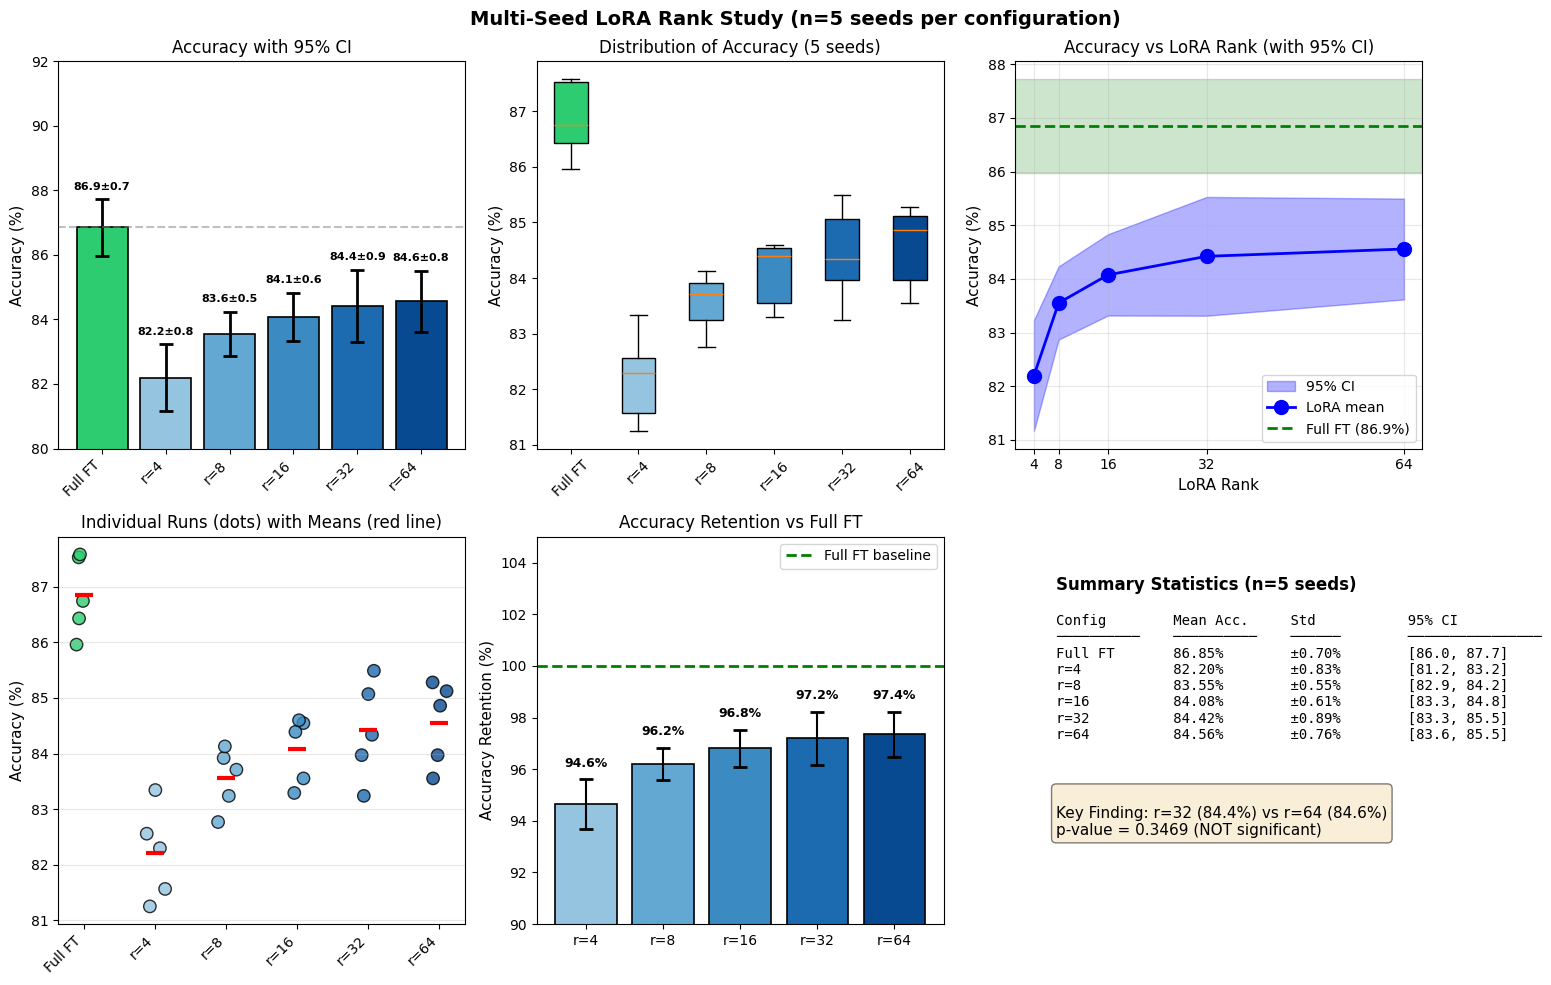


Chart saved to: lora_multiseed_results.png


In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Prepare data
configs = [agg.config_name for agg in aggregated_results]
means = [agg.accuracy_mean * 100 for agg in aggregated_results]
stds = [agg.accuracy_std * 100 for agg in aggregated_results]
ci_lowers = [
    (agg.accuracy_mean - agg.accuracy_ci_lower) * 100 for agg in aggregated_results
]
ci_uppers = [
    (agg.accuracy_ci_upper - agg.accuracy_mean) * 100 for agg in aggregated_results
]
params_pct = [agg.params_updated_pct for agg in aggregated_results]

# Color scheme
colors = ["#2ecc71"] + plt.cm.Blues(np.linspace(0.4, 0.9, len(LORA_RANKS))).tolist()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle(
    "Multi-Seed LoRA Rank Study (n=5 seeds per configuration)",
    fontsize=14,
    fontweight="bold",
)

# 1. Bar chart with error bars (95% CI)
ax1 = axes[0, 0]
x = np.arange(len(configs))
bars = ax1.bar(x, means, color=colors, edgecolor="black", linewidth=1.2)
ax1.errorbar(
    x,
    means,
    yerr=[ci_lowers, ci_uppers],
    fmt="none",
    color="black",
    capsize=5,
    capthick=2,
    linewidth=2,
)
ax1.set_ylabel("Accuracy (%)", fontsize=11)
ax1.set_title("Accuracy with 95% CI", fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(
    ["Full FT"] + [f"r={r}" for r in LORA_RANKS], rotation=45, ha="right"
)
ax1.set_ylim(80, 92)
ax1.axhline(y=means[0], color="gray", linestyle="--", alpha=0.5)
for i, (m, s) in enumerate(zip(means, stds)):
    ax1.text(
        i,
        m + ci_uppers[i] + 0.3,
        f"{m:.1f}±{s:.1f}",
        ha="center",
        fontsize=8,
        fontweight="bold",
    )

# 2. Box plot of individual runs
ax2 = axes[0, 1]
all_accs = [
    [r.accuracy * 100 for r in results_by_config[config]]
    for config in ["Full Fine-Tuning"] + [f"LoRA r={r}" for r in LORA_RANKS]
]
bp = ax2.boxplot(
    all_accs, patch_artist=True, labels=["Full FT"] + [f"r={r}" for r in LORA_RANKS]
)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
ax2.set_ylabel("Accuracy (%)", fontsize=11)
ax2.set_title("Distribution of Accuracy (5 seeds)", fontsize=12)
ax2.tick_params(axis="x", rotation=45)

# 3. Accuracy vs LoRA Rank with CI bands
ax3 = axes[0, 2]
lora_ranks_only = LORA_RANKS
lora_means = means[1:]
lora_ci_lowers = [
    aggregated_results[i + 1].accuracy_ci_lower * 100 for i in range(len(LORA_RANKS))
]
lora_ci_uppers = [
    aggregated_results[i + 1].accuracy_ci_upper * 100 for i in range(len(LORA_RANKS))
]

ax3.fill_between(
    lora_ranks_only,
    lora_ci_lowers,
    lora_ci_uppers,
    alpha=0.3,
    color="blue",
    label="95% CI",
)
ax3.plot(
    lora_ranks_only, lora_means, "bo-", linewidth=2, markersize=10, label="LoRA mean"
)
ax3.axhline(
    y=means[0],
    color="green",
    linestyle="--",
    linewidth=2,
    label=f"Full FT ({means[0]:.1f}%)",
)
ax3.axhspan(
    aggregated_results[0].accuracy_ci_lower * 100,
    aggregated_results[0].accuracy_ci_upper * 100,
    alpha=0.2,
    color="green",
)
ax3.set_xlabel("LoRA Rank", fontsize=11)
ax3.set_ylabel("Accuracy (%)", fontsize=11)
ax3.set_title("Accuracy vs LoRA Rank (with 95% CI)", fontsize=12)
ax3.set_xticks(lora_ranks_only)
ax3.legend(loc="lower right")
ax3.grid(True, alpha=0.3)

# 4. Scatter plot of all individual runs
ax4 = axes[1, 0]
for i, (config, color) in enumerate(
    zip(["Full Fine-Tuning"] + [f"LoRA r={r}" for r in LORA_RANKS], colors)
):
    runs = results_by_config[config]
    x_jitter = i + np.random.uniform(-0.15, 0.15, len(runs))
    ax4.scatter(
        x_jitter,
        [r.accuracy * 100 for r in runs],
        c=[color] * len(runs),
        s=80,
        edgecolors="black",
        linewidth=1,
        alpha=0.8,
    )
    ax4.scatter(
        [i],
        [np.mean([r.accuracy * 100 for r in runs])],
        c="red",
        s=150,
        marker="_",
        linewidths=3,
        zorder=5,
    )
ax4.set_xticks(range(len(configs)))
ax4.set_xticklabels(
    ["Full FT"] + [f"r={r}" for r in LORA_RANKS], rotation=45, ha="right"
)
ax4.set_ylabel("Accuracy (%)", fontsize=11)
ax4.set_title("Individual Runs (dots) with Means (red line)", fontsize=12)
ax4.grid(True, alpha=0.3, axis="y")

# 5. Accuracy retention with CI
ax5 = axes[1, 1]
baseline_mean = aggregated_results[0].accuracy_mean
retentions = [
    (agg.accuracy_mean / baseline_mean) * 100 for agg in aggregated_results[1:]
]
retention_stds = [
    (agg.accuracy_std / baseline_mean) * 100 for agg in aggregated_results[1:]
]
bars5 = ax5.bar(
    range(len(LORA_RANKS)),
    retentions,
    color=colors[1:],
    edgecolor="black",
    linewidth=1.2,
)
ax5.errorbar(
    range(len(LORA_RANKS)),
    retentions,
    yerr=retention_stds,
    fmt="none",
    color="black",
    capsize=5,
    capthick=2,
)
ax5.axhline(y=100, color="green", linestyle="--", linewidth=2, label="Full FT baseline")
ax5.set_xticks(range(len(LORA_RANKS)))
ax5.set_xticklabels([f"r={r}" for r in LORA_RANKS])
ax5.set_ylabel("Accuracy Retention (%)", fontsize=11)
ax5.set_title("Accuracy Retention vs Full FT", fontsize=12)
ax5.set_ylim(90, 105)
ax5.legend()
for i, (ret, std) in enumerate(zip(retentions, retention_stds)):
    ax5.text(
        i, ret + std + 0.5, f"{ret:.1f}%", ha="center", fontsize=9, fontweight="bold"
    )

# 6. Summary statistics table
ax6 = axes[1, 2]
ax6.axis("off")
table_data = [
    ["Config", "Mean Acc.", "Std", "95% CI"],
    ["─" * 10, "─" * 10, "─" * 6, "─" * 16],
]
for agg in aggregated_results:
    name = "Full FT" if agg.lora_rank is None else f"r={agg.lora_rank}"
    ci = f"[{agg.accuracy_ci_lower * 100:.1f}, {agg.accuracy_ci_upper * 100:.1f}]"
    table_data.append(
        [name, f"{agg.accuracy_mean * 100:.2f}%", f"±{agg.accuracy_std * 100:.2f}%", ci]
    )

table_text = "\n".join(["  ".join(f"{col:<12}" for col in row) for row in table_data])
ax6.text(
    0.1,
    0.9,
    "Summary Statistics (n=5 seeds)",
    fontsize=12,
    fontweight="bold",
    transform=ax6.transAxes,
    verticalalignment="top",
)
ax6.text(
    0.1,
    0.8,
    table_text,
    fontsize=10,
    family="monospace",
    transform=ax6.transAxes,
    verticalalignment="top",
)

# Add key finding
r32_mean = aggregated_results[4].accuracy_mean * 100
r64_mean = aggregated_results[5].accuracy_mean * 100
t_stat, p_value = stats.ttest_rel(lora_accs[32], lora_accs[64])
finding = f"\nKey Finding: r=32 ({r32_mean:.1f}%) vs r=64 ({r64_mean:.1f}%)\np-value = {p_value:.4f}"
if p_value >= 0.05:
    finding += " (NOT significant)"
else:
    finding += " (significant)"
ax6.text(
    0.1,
    0.35,
    finding,
    fontsize=11,
    transform=ax6.transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)

plt.tight_layout()
plt.savefig("lora_multiseed_results.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nChart saved to: lora_multiseed_results.png")

## 11. Save All Results


In [14]:
# Save individual runs
individual_results = [asdict(r) for r in all_results]
with open("multiseed_individual_runs.json", "w") as f:
    json.dump(individual_results, f, indent=2)

# Save aggregated results
aggregated_data = []
for agg in aggregated_results:
    d = asdict(agg)
    # Convert numpy types to Python types for JSON
    for key in [
        "accuracy_mean",
        "accuracy_std",
        "accuracy_ci_lower",
        "accuracy_ci_upper",
        "f1_mean",
        "f1_std",
        "time_mean",
        "vram_mean",
    ]:
        if key in d:
            d[key] = float(d[key])
    aggregated_data.append(d)

with open("multiseed_aggregated_results.json", "w") as f:
    json.dump(aggregated_data, f, indent=2)

print("Results saved:")
print("  - multiseed_individual_runs.json (30 runs)")
print("  - multiseed_aggregated_results.json (6 configs with stats)")
print("  - lora_multiseed_results.png (visualization)")

Results saved:
  - multiseed_individual_runs.json (30 runs)
  - multiseed_aggregated_results.json (6 configs with stats)
  - lora_multiseed_results.png (visualization)


In [15]:
# Final summary
print("\n" + "=" * 100)
print("FINAL CONCLUSIONS")
print("=" * 100)

# Find best LoRA
best_lora = max(aggregated_results[1:], key=lambda x: x.accuracy_mean)
full_ft = aggregated_results[0]

print(f"""
1. FULL FINE-TUNING BASELINE:
   Mean Accuracy: {full_ft.accuracy_mean * 100:.2f}% ± {full_ft.accuracy_std * 100:.2f}%
   95% CI: [{full_ft.accuracy_ci_lower * 100:.2f}%, {full_ft.accuracy_ci_upper * 100:.2f}%]

2. BEST LoRA CONFIGURATION:
   {best_lora.config_name}
   Mean Accuracy: {best_lora.accuracy_mean * 100:.2f}% ± {best_lora.accuracy_std * 100:.2f}%
   95% CI: [{best_lora.accuracy_ci_lower * 100:.2f}%, {best_lora.accuracy_ci_upper * 100:.2f}%]
   Accuracy Retention: {(best_lora.accuracy_mean / full_ft.accuracy_mean) * 100:.1f}%
   Parameters: {best_lora.params_updated_pct}%

3. r=32 vs r=64 COMPARISON:
   r=32: {aggregated_results[4].accuracy_mean * 100:.2f}% ± {aggregated_results[4].accuracy_std * 100:.2f}%
   r=64: {aggregated_results[5].accuracy_mean * 100:.2f}% ± {aggregated_results[5].accuracy_std * 100:.2f}%
   Difference: {(aggregated_results[4].accuracy_mean - aggregated_results[5].accuracy_mean) * 100:+.2f}pp
   p-value: {stats.ttest_rel(lora_accs[32], lora_accs[64])[1]:.4f}

4. KEY INSIGHT:
   All LoRA configurations reduce parameters by 97.8-99.2% while retaining
   {min([agg.accuracy_mean / full_ft.accuracy_mean * 100 for agg in aggregated_results[1:]]):.1f}%-{max([agg.accuracy_mean / full_ft.accuracy_mean * 100 for agg in aggregated_results[1:]]):.1f}% of full fine-tuning accuracy.
""")


FINAL CONCLUSIONS

1. FULL FINE-TUNING BASELINE:
   Mean Accuracy: 86.85% ± 0.70%
   95% CI: [85.98%, 87.73%]

2. BEST LoRA CONFIGURATION:
   LoRA r=64
   Mean Accuracy: 84.56% ± 0.76%
   95% CI: [83.62%, 85.50%]
   Accuracy Retention: 97.4%
   Parameters: 2.16%

3. r=32 vs r=64 COMPARISON:
   r=32: 84.42% ± 0.89%
   r=64: 84.56% ± 0.76%
   Difference: -0.14pp
   p-value: 0.3469

4. KEY INSIGHT:
   All LoRA configurations reduce parameters by 97.8-99.2% while retaining
   94.6%-97.4% of full fine-tuning accuracy.



In [16]:
# Download files (Colab)
try:
    from google.colab import files

    files.download("multiseed_individual_runs.json")
    files.download("multiseed_aggregated_results.json")
    files.download("lora_multiseed_results.png")
except:
    print("Not in Colab - files saved locally")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

## Summary

This multi-seed experiment provides:

1. **Statistical validity** - 5 seeds per configuration with 95% confidence intervals
2. **Proper comparison** - Paired t-tests for r=32 vs r=64 and other comparisons
3. **Publishable conclusions** - Based on variance, not point estimates

---

_ValtricAI Research - December 2025_
